In [81]:
import os
import sys
sys.path.append("/home/henryrpg/Desktop/N3AS/Emu_scripts/data_reduction")
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
from scipy import optimize as opt
import h5py
import amrex_plot_tools as amrex
import emu_yt_module as emu
import spin_flip_tools as sft
import glob
import concurrent
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,LogLocator)
from matplotlib import cm, colors
import matplotlib.axes as ax
from mpl_toolkits.mplot3d import Axes3D
import latex
from itertools import product

# For ease of development, reload the relevant modules to make sure they are up to date.
import importlib
importlib.reload(sft)

c = 299792458 #m/s
hbar =6.582119569E-16 #eV s
G=1.1663787E-23 # eV^-2 (fermi constant)
M_p=1.6726219*10**(-24)#grams (Proton mass)

################
# plot options #
################
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'serif'
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rc('text', usetex=True)
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = False
plt.show()
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
def sin(theta):
    return np.sin(theta)
def cos(theta):
    return np.cos(theta)
def exp(x):
    return np.exp(x)
pi=np.pi

/home/henryrpg/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


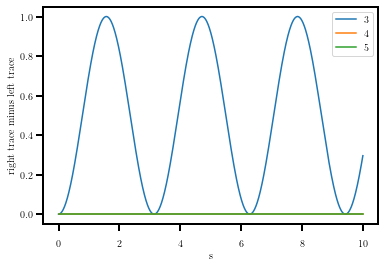

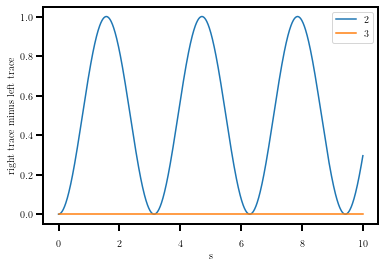

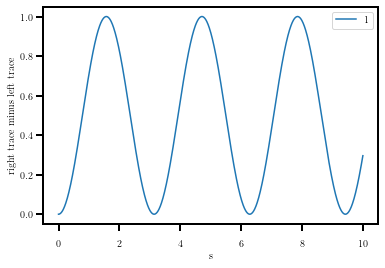

In [6]:
spinflip_directory = "/home/henryrpg/Desktop/N3AS/data/criticalpoint_spin_flip_matrices_z.h5"

def Hamiltonian(sf_file,t):
    H_L = sft.total(sf_file, 'H_Lz(eV)')

    H_R = sft.total(sf_file, 'H_Rz(eV)')
    H_LR = sft.total(sf_file, 'H_LR(eV)')

    return np.average(np.concatenate((np.concatenate( (H_R, np.conjugate(H_LR.transpose(0,2,1,3))), axis=1),
                    np.concatenate((H_LR, H_L), axis = 1)), axis = 2), axis= 3)[t,:,:]


class Diagonalizer:
    def __init__(self, filepath, t=0, H = None):
        
        self.sf_file = h5py.File(filepath,'r')
            
        #get Hamiltonian
        if H is None:
            self.H = Hamiltonian(self.sf_file, t)
        else: 
            self.H = H
        self.Hsize = self.H.shape[1]
        #list of eigenvalues 
        self.eigenvals = (1+0*1j)*np.real(np.linalg.eig(self.H)[0] )

        #(inverted) array of normalized eigenvectors
        #a.k.a. change of basis matrix from Energy to flavor/spin
        #ket_f = f_to_e(ket_e)
        #H_f = (f_to_e) H_diag (e_to f)^-1
        self.f_to_e = (1+0*1j)*np.linalg.inv(np.linalg.eig(self.H)[1]) 
        
        self.H_diag = self.f_to_e @ self.H @ np.linalg.inv(self.f_to_e)
    #Time evolution operator in energy basis
    def U_energy(self, t):
        return np.diag([exp(-1j*eigenvalue*t) for eigenvalue in self.eigenvals])
   
    def U_flavor(self, t):
        return np.linalg.inv(self.f_to_e) @ self.U_energy(t) @ self.f_to_e
   
    #time array of neutrino density matrix, with init_array as intial condition
    def state_evolution(self, resolution, t_lim, init_array):
        return np.array([self.U_flavor(t) @ init_array @ np.linalg.inv(self.U_flavor(t)) for t in np.linspace(0, t_lim, resolution)])
    
    def state_evolution_plotter(self, resolution, t_lim, init_array = np.diag((1,0,0,0,0,0))):
        flavornum = self.Hsize//2
        #s_vs_t.shape = t,2nf,2nf
        state_vs_time = self.state_evolution(resolution, t_lim, init_array)
        state_left = np.trace(state_vs_time[:,0:flavornum,0:flavornum], axis1= 1, axis2 = 2)
        state_right = np.trace(state_vs_time[:,flavornum:2*flavornum,flavornum:2*flavornum], axis1= 1, axis2 = 2)
        left_minus_right = state_left - state_right
        
        nth_diagonal = np.array([state_vs_time[:,n,n] for n in np.arange(0,2*flavornum)])
        
        #electron_part = self.state_evolution(resolution, t_lim, init_array)[:,0,0]
        f, ax = plt.subplots()
        ax.set_ylabel('right trace minus left trace')
        ax.set_xlabel('s')
        #ax.set_ylim(0,2E-15)
        qty = state_right
        #ax.plot(np.linspace(0,t_lim,resolution),qty)
        for n in np.arange(flavornum,2*flavornum):
            ax.plot(np.linspace(0,t_lim,resolution),nth_diagonal[n], label = str(n))
        ax.legend()
        
        
        
        
        
Htest= np.zeros((6,6))
Htest[3,0]=1
Htest[0,3]=1

Htest_2f= np.zeros((4,4))
Htest_2f[2,0]=1
Htest_2f[0,2]=1

Diagonalizer(spinflip_directory, 0, H = Htest).state_evolution_plotter(1000,1E1, init_array = np.diag((1,0,0,0,0,0)))
Diagonalizer(spinflip_directory, 100, H=Htest_2f).state_evolution_plotter(1000,1E1, init_array = np.diag((1,0,0,0)))
Diagonalizer(spinflip_directory, 100, H= np.array([[0,1],[1,0]])).state_evolution_plotter(1000,1E1, init_array = np.diag((1,0)))


#Diagonalizer(directory, simulation_t, H).state_evolution_plotter(resolution, xlim, init_arrayf)

In [123]:
def gellmann(j, k, d):
    r"""Returns a generalized Gell-Mann matrix of dimension d. According to the
    convention in *Bloch Vectors for Qubits* by Bertlmann and Krammer (2008),
    returns :math:`\Lambda^j` for :math:`1\leq j=k\leq d-1`,
    :math:`\Lambda^{kj}_s` for :math:`1\leq k<j\leq d`,
    :math:`\Lambda^{jk}_a` for :math:`1\leq j<k\leq d`, and
    :math:`I` for :math:`j=k=d`.

    :param j: First index for generalized Gell-Mann matrix
    :type j:  positive integer
    :param k: Second index for generalized Gell-Mann matrix
    :type k:  positive integer
    :param d: Dimension of the generalized Gell-Mann matrix
    :type d:  positive integer
    :returns: A genereralized Gell-Mann matrix.
    :rtype:   numpy.array

    """

    if j > k:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = 1
        gjkd[k - 1][j - 1] = 1
    elif k > j:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = -1.j
        gjkd[k - 1][j - 1] = 1.j
    elif j == k and j < d:
        gjkd = np.sqrt(2/(j*(j + 1)))*np.diag([1 + 0.j if n <= j
                                               else (-j + 0.j if n == (j + 1)
                                                     else 0 + 0.j)
                                               for n in range(1, d + 1)])
    else:
        gjkd = np.diag([1 + 0.j for n in range(1, d + 1)])

    return gjkd


def get_GM(d):
    r'''Return a basis of orthogonal Hermitian operators on a Hilbert space of
    dimension d, with the identity element in the last place.

    '''
    return np.array([gellmann(j, k, d) for j, k in product(range(1, d + 1), repeat=2)])

# finds Gell Mann projection vector of a matrix
def GM_projection(M):
    matrix_size = np.shape(M)[0]
    GM_components = get_GM(matrix_size)
    return np.array([np.trace(0.5*GM_components[n] @ M) for n in np.arange(0, matrix_size**2-1)])

#scalar magnitude of GM projection
def GM_magnitude(M):
    return np.linalg.norm(GM_projection(M))

#returns H dot P as Gell Mann projection vectors. Resonance occurs when this is 0 
def GM_dotprod(H, P):
    if np.shape(H)[0] != np.shape(P)[0]:
        raise TypeError('H and P have different dimensions')
        return
    else: 
        return np.dot(np.real(GM_projection(H)),np.real(GM_projection(P)))
    
#takes in value that depends on theta, phi and returns a theta_res by phi_res array of values 
def angularArray(func, theta_res, phi_res):   
    return np.array([[func(theta, phi) for phi in np.linspace(0, 2*pi, phi_res)]
                                      for theta in np.linspace(0, pi, theta_res)])


In [172]:
#Given a spinflip dataset, finds the hamiltonian at some angle and evolves it. Can also check resonant direction
class SpinParams:
    def __init__(self, t_sim = 0, data_loc = "/home/henryrpg/Desktop/N3AS/data/criticalpoint_spin_flip_matrices_z.h5", 
                 p_abs=10**7, location = None, merger_data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5"):
        
        self.data_loc = data_loc
        self.h5file = h5py.File(self.data_loc, "r")
 
        self.p_abs = p_abs
        self.t_sim = t_sim
         
        #Grid-dependent stuff: Electron fraction, baryon n density
        if location != None:   
            self.merger_grid = h5py.File(merger_data_loc, 'r')
            self.rho = np.array(self.merger_grid['rho(g|ccm)'])[location[0],location[1],location[2]] #g/cm^3 (baryon mass density)
            self.Ye = np.array(self.merger_grid['Ye'])[location[0],location[1],location[2]]
            self.n_b = self.rho/M_p*(hbar**3 * c**3)#eV^3 (baryon number density)
        else: 
            self.Ye = 0.21690808855662308
            self.rho = 50091419880.43257
            self.n_b = self.rho/M_p*(hbar**3 * c**3)
            
        #Flux (spacetime, F, F, z)
        self.J = sft.total(self.h5file, 'J(eV^3)')[self.t_sim]
       
        #length of 1d array 
        self.nz = self.J.shape[3]
        
        #neutrino part of Sigma
        self.S_R_nu = sft.sigma(self.J)[0]
        self.S_L_nu = sft.sigma(self.J)[1]
        
        #matter part of Sigma
        self.S_R_mat = np.zeros(np.shape(self.J))  
        for k in np.arange(0, self.nz):
            self.S_R_mat[0,:,:,k] = 2**(-1/2)*G*self.n_b*np.array([[3*self.Ye-1,    0,      0],
                                              [0,           self.Ye-1, 0],
                                              [0,              0,   self.Ye-1 ]])
        self.S_L_mat = (-1)*np.transpose(self.S_R_mat, axes=(0,2,1,3))   
        
        #Total Sigma
        self.S_R = self.S_R_nu + self.S_R_mat
        self.S_L = self.S_L_nu + self.S_R_mat
        
        #Mass part
        self.M = sft.M_3flavor
        self.H_vac = 1/(2*self.p_abs)*np.matmul(self.M,sft.conj(self.M))
        
        

    def S_L_kappa(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return np.average(sft.kappa(self.S_L, basis), axis = 2)

    def S_R_kappa(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return np.average(sft.kappa(self.S_R, basis), axis = 2)

    def H_L_pm(self, theta, phi):
        basis = sft.Basis(theta,phi)
        S_L_minus = sft.minus(self.S_L, basis)
        S_L_plus = sft.plus(self.S_L, basis)
        H_L_pm = 2./self.p_abs * np.array([np.matmul(S_L_minus[:,:,z], S_L_plus[:,:,z])
            for z in range(self.nz)]).transpose((1,2,0))
        return np.average(H_L_pm, axis=2)

    def H_R_pm(self, theta, phi):
        basis = sft.Basis(theta,phi)
        S_R_minus = sft.minus(self.S_R, basis)
        S_R_plus = sft.plus(self.S_R, basis)
        H_R_pm = 2./self.p_abs * np.array([np.matmul(S_R_plus[:,:,z], S_R_minus[:,:,z])
            for z in range(self.nz)]).transpose((1,2,0))
        return  np.average(H_R_pm, axis = 2)


    #NO DERIVATIVE TERM
    def H_L(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return self.S_L_kappa(theta, phi) + self.H_vac + self.H_L_pm(theta, phi)

    def H_R(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return self.S_R_kappa(theta, phi) + self.H_vac + self.H_R_pm(theta, phi)

    def H_LR(self, theta, phi):          
        basis = sft.Basis(theta, phi)
        S_L_plus = np.average(sft.plus(self.S_L, basis), axis = 2)
        S_R_plus = np.average(sft.plus(self.S_R, basis), axis = 2)

        MSl = np.array(np.matmul(np.conj(self.M),S_L_plus))
        SrM = np.array(np.matmul(S_R_plus,np.conj(self.M)))
        return (-1/self.p_abs)*(SrM-MSl)


    #full Hamiltonian
    def H(self, theta, phi):
        return np.concatenate((np.concatenate( (self.H_R(theta, phi), np.conjugate(self.H_LR(theta,phi).transpose(1,0))), axis=0),
                np.concatenate((self.H_LR(theta,phi), self.H_L(theta,phi)), axis = 0)), axis = 1)

    #NEED DEFINITION OF DENSITY MATRIX
    def P(self, theta, phi):
        return




    def resonance_full(self, theta, phi):
        return GM_dotprod(self.H(theta,phi),self.P(theta,phi))

    #checks resonance condition [H_L]_f1f1 = [H_R]_f2f2
    #equals resonance from tian et al if f1=f2=0 (electron)
    def resonance_2f(self, theta, phi, f1, f2):
        return self.H(theta,phi)[f1,f1]-self.H(theta,phi)[f2,f2]

    def resonance_old(self, theta, phi):
        return 2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+self.S_R_kappa(theta,phi)[0,0]

    def angularPlot(self, theta_res, phi_res):
            
        H_LR_array = np.array([[GM_magnitude(self.H_LR(theta, phi)) 
                                   for phi in np.linspace(0, 2*pi, phi_res)]
                                   for theta in np.linspace(0, pi, theta_res)])

        resonance_array = np.array([[self.resonance_old(theta,phi)
                                   for phi in np.linspace(0, 2*pi, phi_res)]
                                   for theta in np.linspace(0, pi, theta_res)]) 

        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)

        H_LR_im = ax.pcolormesh(np.linspace(-np.pi, np.pi, phi_res), 
                                np.linspace(0.5*np.pi, -0.5*np.pi, theta_res),
                                H_LR_array, 
                                cmap=plt.cm.hot, shading='auto')

        plt.colorbar(H_LR_im)

        #resonance 
        res_im = ax.contour(np.linspace(-np.pi, np.pi, phi_res),
                            np.linspace(0.5*np.pi, -0.5*np.pi, theta_res),
                            resonance_array, levels=[0.], colors='cyan')

        #add net flux point 
        J_avg = np.array([GM_magnitude(np.average(self.J[n], axis = 2)) for n in range(0,4)])
        ax.scatter([np.arctan2(J_avg[2],J_avg[1])],[np.arctan2(J_avg[3],
                                                (J_avg[1]**2+J_avg[2]**2)**(1/2))],label = 'ELN Flux Direction')


/tmp/ipykernel_164/579264795.py:140: UserWarning: No contour levels were found within the data range.
  res_im = ax.contour(np.linspace(-np.pi, np.pi, phi_res),


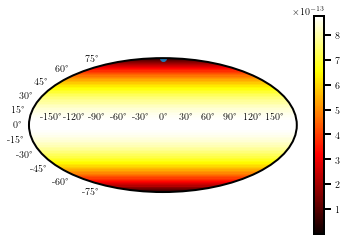

In [173]:
x=SpinParams()
x.angularPlot(100,100)

In [151]:
SpinParams_0 = SpinParams()
array = angularArray(SpinParams_0.resonance_old, 500,500)
#opt.bisect()

In [171]:
np.where(array>0)

(array([], dtype=int64), array([], dtype=int64))

In [153]:
res_function = SpinParams_0.resonance_old

In [159]:
res_function(pi,0)

(-1.5531895680078845e-06+0j)

In [154]:
opt.bisect(res_function,0,pi,args = (0))

/home/henryrpg/.local/lib/python3.8/site-packages/scipy/optimize/zeros.py:549: ComplexWarning: Casting complex values to real discards the imaginary part
  r = _zeros._bisect(f, a, b, xtol, rtol, maxiter, args, full_output, disp)


ValueError: f(a) and f(b) must have different signs

In [ ]:
#how do I make this work for any quantity?
        def angular_plot(self, qty, theta_precision = 200, phi_precision = 100, savefig = True):
            
            H_LR_array = angularArray(GM_Magnitude(self.H_LR))
            
            H_LR_angular = np.transpose((np.array([[((np.real(self.H_LR_at_basis(theta,phi)[0,0]))**2
                                               + (np.imag(self.H_LR_at_basis(theta,phi)[0,0]))**2)**(1/2)
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
            resonance_angular = np.transpose((np.array([[np.real(self.resonance_at_basis(theta,phi))  
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        
        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)
        H_LR_im = ax.pcolormesh(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         H_LR_angular, 
                         cmap=plt.cm.hot, shading='auto')
        plt.colorbar(H_LR_im)
        
        res_im = ax.contour(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         resonance_angular, levels=0, colors='cyan')
        
        #add net flux point 
        ax.scatter([np.arctan2(self.J[2],self.J[1])],[np.arctan2(self.J[3],
                                                (self.J[1]**2+self.J[2]**2)**(1/2))],label = 'ELN Flux Direction')
        
        #ax.scatter([np.arctan2(self.J_tot[2],self.J_tot[1])],
         #          [np.arctan2(self.J_tot[3],(self.J_tot[1]**2+self.J_tot[2]**2)**(1/2))],
          #         label = 'Main Particle Flow')
        #ax.legend()
        #ax.set_title(r'$Angular \  Plot \ of \ H_{LR}$')
        #ax.facecolor='white'
        
        #if savefig == True:
        #    plt.tight_layout()
        #    plt.savefig('../angularplot.png', dpi=300 )
        #plt.show()

In [ ]:

class AngularPlots:
    def __init__(self, theta_res, phi_res,
                 data_loc = "/home/henryrpg/Desktop/N3AS/data/criticalpoint_spin_flip_matrices_z.h5", 
                 merger_data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5",
                 p_abs=10**7, t_sim = 0,
                 location = None )
        
    def angular_plot(self, theta_precision = 200, phi_precision = 100, savefig = True):
        
        H_LR_angular = np.transpose((np.array([[((np.real(self.H_LR_at_basis(theta,phi)[0,0]))**2
                                               + (np.imag(self.H_LR_at_basis(theta,phi)[0,0]))**2)**(1/2)
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        resonance_angular = np.transpose((np.array([[np.real(self.resonance_at_basis(theta,phi))  
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        
        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)
        H_LR_im = ax.pcolormesh(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         H_LR_angular, 
                         cmap=plt.cm.hot, shading='auto')
        plt.colorbar(H_LR_im)
        
        res_im = ax.contour(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         resonance_angular, levels=0, colors='cyan')
        
        #add net flux point 
        ax.scatter([np.arctan2(self.J[2],self.J[1])],[np.arctan2(self.J[3],
                                                (self.J[1]**2+self.J[2]**2)**(1/2))],label = 'ELN Flux Direction')
        
        #ax.scatter([np.arctan2(self.J_tot[2],self.J_tot[1])],
         #          [np.arctan2(self.J_tot[3],(self.J_tot[1]**2+self.J_tot[2]**2)**(1/2))],
          #         label = 'Main Particle Flow')
        #ax.legend()
        #ax.set_title(r'$Angular \  Plot \ of \ H_{LR}$')
        #ax.facecolor='white'
        
        #if savefig == True:
        #    plt.tight_layout()
        #    plt.savefig('../angularplot.png', dpi=300 )
        #plt.show()